#1. 데이터 읽기

In [ ]:
import pandas as pd
from sklearn.datasets import load_boston

#boston 데이터셋 로드
boston = load_boston()

#boston dataset을 DataFrame으로 전환
df_boston = pd.DataFrame(boston.data, columns = boston.feature_names)
#boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함.
df_boston['PRICE'] = boston.target
print(f'Boston 데이터셋 크기 {df_boston.shape}')
df_boston.head()

Boston 데이터셋 크기 (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


> * CRIM: 지역별 범죄 발생률
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* NDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* MEDV: 본인 소유의 주택 가격(중앙값)

#2. 각 feature별 주택 가격 영향도 조사

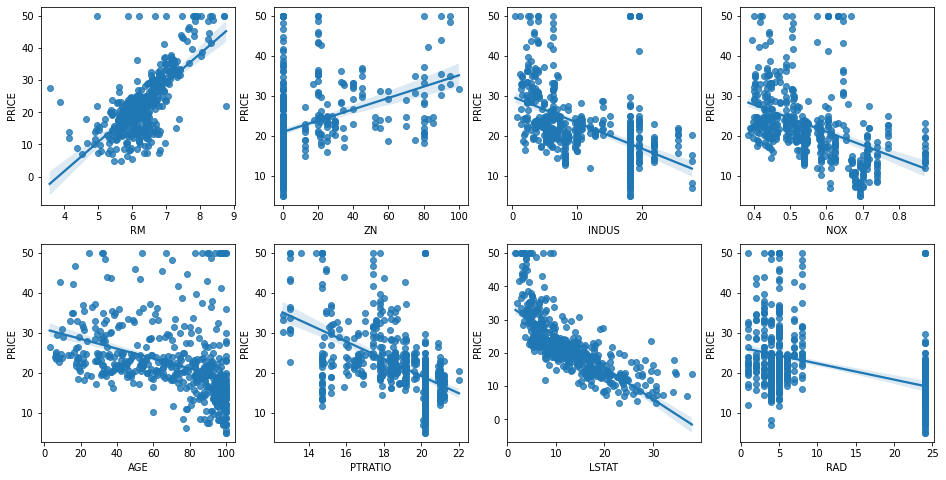

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#2개의 행과 4개의 열을 가진 subplots를 이용 axs는 4X2개의 ax를 가짐.
fig, axs = plt.subplots(figsize = (16,8), ncols = 4, nrows =2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = i//4
    col = i%4
    #seaborn의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x = feature, y = 'PRICE', data=df_boston, ax=axs[row][col])

> 실행 결과 RM(방수), LSTAT(하위 계층 비율) 두 가지가 가격에 영향을 미치는 것으로 판단된다.

#3. 모델 만들기

##3.1 모델 만들기

In [ ]:
df_labels = df_boston['PRICE']
df_data = df_boston.drop(['PRICE'], axis =1, inplace =False)

> 예측할 가격과 데이터를 구분한다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size =0.3, random_state =156)

#Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7572263323138941

> 예측 평점은 75점으로 낮게 나타났다.

#4. 성능평가

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print(f'MSE : {mse:.3f}, RMSE : {rmse:.3f}')
print(f'Variance score : {r2_score(y_test, y_preds):.4f}')

MSE : 17.297, RMSE : 4.159
Variance score : 0.7572


> 위와 같이 각 지표별 결과를 확인할 수 있다.

#5. 교차검증

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

> 데이터와 모델 생성

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np

#cross_val_score()로 5Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, df_data , df_labels,
                                scoring = 'neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


> 예측 모델에서는 데이터가 크면 클 수록 좋다는 판단을 하게 된다. 하지만 회귀 모델에서는 실데이터와 예측데이터의 거리가 크면 그만큼 예측이 잘못된 것이 된다. 따라서 큰 수를 잘못된 예측으로 표현하기 위해 음수를 적용한 성능 평가를 해야 했고 이를 위해 neg_mean_squared_error를 성능 지표로 사용했다.